In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats

### Demonstrate that the p-value is uniformly distributed under $H_0$

In this demonstration, we are testing whether the sampled values come from the standard normal distribution (spoiler: they do!). That is:

$$H_0: \text{the sampled values come from } N(\mu=0,\sigma=1)$$
$$H_A: \text{the sampled values do not come from } N(\mu=0,\sigma=1)$$
##### Sample from the standard normal distribution 
We will start by sampling 1000 times from the standard normal distribution ($\mu=0, \sigma=1$) using `scipy.stats.norm.rvs`. 

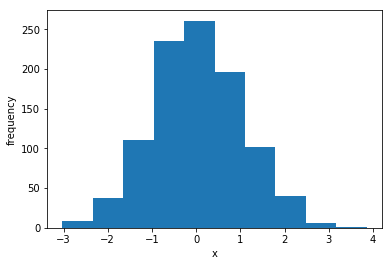

In [2]:
# 1000 samples from standard normal distribution
sample = stats.norm.rvs(loc = 0, scale = 1, size = 1000)
plt.hist(sample)
plt.xlabel('x')
plt.ylabel('frequency')
plt.show()

##### Compute p-values
For each of the sampled values, we will compute the p-value, or the probability of observing a value _at least_ as extreme as the observed value under $H_0$. To do this, we can compute the cumulative density function (CDF) for the standard normal distribution at each sampled value. The CDF, evaluated at some value $x$, gives the probability that the specified distribution will take on a value less than or equal to $x$. This is the equivalent of a one-sided statistical test for the lower-tail.

Note: Evaluating the survival function, or $1-CDF_{\mu,\sigma}(x)$, because this would be the equivalent of a one-sided statistical test for the upper tail.

In this tutorial, will use the [scipy implementations](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html) of the CDF and the survival function - or $\left(1-CDF \right)$ - for the normal distribution: `scipy.stats.norm.cdf` and `scipy.stats.norm.sf`.

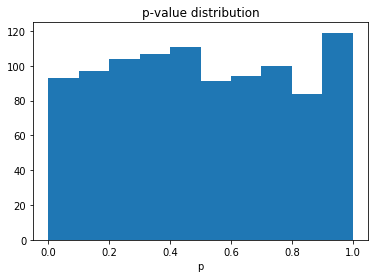

In [3]:
# compute p-values
pvals = stats.norm.cdf(sample, loc = 0, scale = 1)
plt.hist(pvals)
plt.xlabel('p')
plt.title('p-value distribution')
plt.show()

##### QQ-plot of p-values

Here, we will show you how to plot your own QQ-plot, and visualize what a QQ-plot should look like when the observed values follow the theoretical distribution.

If you recall, the QQ-plot is a plot of one set of quantiles against another. For our purposes, we will plot the quantiles of the theoretical distribution on the x-axis and the quantiles of the observed distribution on the y-axis.

What's our theoretical distribution? Under $H_0$, the p-value is **uniformly distributed**. Therefore, for $N$ observed values, the quantiles of the theoretical distribution can be computed by:

$$\frac{i}{N} \forall i\in[0,...,N]$$

To obtain the quantiles of our observed distribution, we will simply sort the values, as the p-values are essentially percentiles already!

But wait - we have to make one more adjustment! Because people are usually interested in small p-values, it's more useful to plot the p-values on a log-scale. Standard practice is to use $-\log_{10}p$. Thus, we are actually plotting the sorted values of $-\log_{10}p$ on the y-axis, and the sorted values of $-\log_{10}(\text{expected})$.

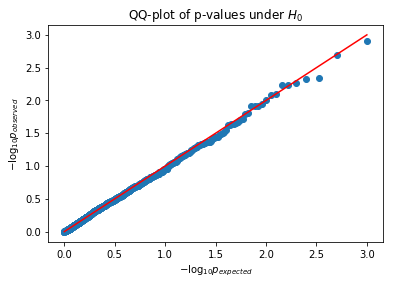

In [4]:
sorted_pvals = sorted(-np.log10(pvals))

plt.scatter(x = sorted(-np.log10(np.arange(1, pvals.shape[0] + 1)/pvals.shape[0])), y = sorted_pvals)
plt.plot(sorted(-np.log10(np.arange(1, pvals.shape[0] + 1)/pvals.shape[0])), 
         sorted(-np.log10(np.arange(1, pvals.shape[0] + 1)/pvals.shape[0])), 'r-')
plt.title(r'QQ-plot of p-values under $H_0$')
plt.xlabel(r'$-\log_{10}p_{expected}$')
plt.ylabel(r'$-\log_{10}p_{observed}$')
plt.show()

### What does the p-value distribution look like when $H_0$ is rejected?

Let's sample from a normal distribution with $\mu=1$ this time, but test whether the mean of the sampled values is greater than that of the standard normal distribution. This is a one-sided upper tail statistical test, and we'll set a significance cutoff of $\alpha=0.05$.

$$H_0: \mu_{sample}= 0$$
$$H_A: \mu_{sample}>0$$

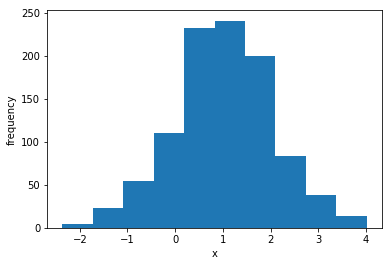

In [5]:
# 1000 samples 
sample2 = stats.norm.rvs(loc = 1, scale = 1, size = 1000)
plt.hist(sample2)
plt.xlabel('x')
plt.ylabel('frequency')
plt.show()

##### Compute p-values

This time, we have to use the survival function, because we are testing for how likely we are to observe a value _greater_ than the sampled value under the standard normal distribution - that is, an upper tail test.

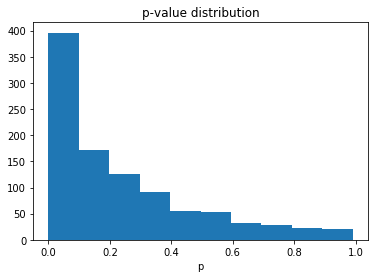

In [6]:
pvals2 = stats.norm.sf(sample2, loc = 0, scale = 1)
plt.hist(pvals2)
plt.xlabel('p')
plt.title('p-value distribution')
plt.show()

##### QQ-plot

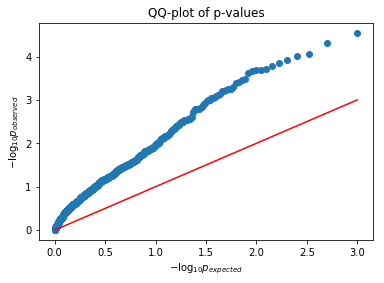

In [7]:
sorted_pvals2 = sorted(-np.log10(pvals2))

plt.scatter(x = sorted(-np.log10(np.arange(1,pvals.shape[0]+1)/pvals.shape[0])), y = sorted_pvals2)

plt.plot(sorted(-np.log10(np.arange(1,pvals2.shape[0]+1)/pvals2.shape[0])), 
         sorted(-np.log10(np.arange(1,pvals2.shape[0]+1)/pvals2.shape[0])), 'r-')

plt.title('QQ-plot of p-values')
plt.xlabel(r'$-\log_{10}p_{expected}$')
plt.ylabel(r'$-\log_{10}p_{observed}$')
plt.show()

### Multiple Testing Correction

Let's perform 1000 independent samples t-tests to test for differences in the means of two sampled groups, A and B, each of size $n=10$. 

Among these 1000 tests, let's predetermine that 100 of them will yield **true positives** - that is, the means of samples A and B come from two different normal distributions. For the rest of the tests, we will sample from the same normal distributions - these are **true negatives**.

##### Let's start by drawing the samples:
- for the **true positive** tests, we will sample 10 values from the standard normal distribution for group A, and 10 values from $N(\mu=1,\sigma=1)$ for group B
- for the **true negative** tests, we will sample 10 values from the standard normal distribution for group A and for group B

In [8]:
Ntests = 1000
TPtests = 100
TNtests = Ntests - TPtests
sampleSize = 10

# True positive cases
tp_samplesA = stats.norm.rvs(size = (TPtests, sampleSize))
tp_samplesB = stats.norm.rvs(loc = 1, scale = 0, size = (TPtests, sampleSize))

# True negative cases
tn_samplesA = stats.norm.rvs(size = (TNtests, sampleSize))
tn_samplesB = stats.norm.rvs(size = (TNtests, sampleSize))

##### Independent samples t-test
We will perform a two-sided, independent samples t-test to determine whether the two samples being compared have the same means:

$$H_0: \mu_A = \mu_B$$
$$H_A: \mu_A \neq \mu_B$$

This test assumes that the populations have identical variances (which is why we kept $\sigma=1$).

We will use the scipy implementation for the t-test: [`scipy.stats.ttest_ind`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [9]:
# concatenate the samples for groups A and B into the same arrays
all_samplesA = np.concatenate((tp_samplesA, tn_samplesA), axis = 0)
all_samplesB = np.concatenate((tp_samplesB, tn_samplesB), axis = 0)

# perform the t-test (row-wise) 
res = stats.ttest_ind(all_samplesA, all_samplesB, axis = 1)

This function returns the test statistic, $t$, and corresponding $p$ for each test performed. Let's take a look at the p-value distribution.

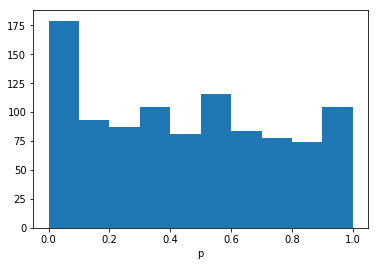

In [10]:
plt.hist(res.pvalue)
plt.xlabel('p')
plt.show()

For a significance cutoff of $\alpha = 0.05$, how many significant p-values do we observe?

In [11]:
nSignificant = sum(res.pvalue < 0.05)
print('%d significant results' % nSignificant)

130 significant results


How many of these are true positives? How many are false positives?

In [12]:
# number of TPs
tp = sum(res.pvalue[:TPtests] < 0.05)
fp = nSignificant - tp
print('%d TPs, %d FPs' % (tp, fp))

82 TPs, 48 FPs


Let's visualize that in the p-value distribution.

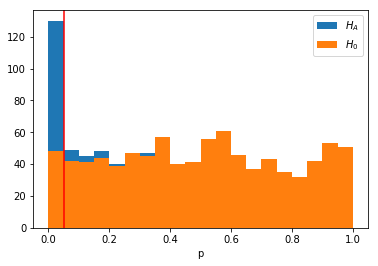

In [13]:
plt.hist(res.pvalue, bins = np.arange(0,1.05,0.05))
plt.hist(res.pvalue[TPtests:], bins = np.arange(0,1.05,0.05))
plt.legend([r'$H_A$',r'$H_0$'])
plt.xlabel('p')
plt.axvline(x = 0.05, color = 'red')
plt.show()

Let's also visualize the QQ-plot.

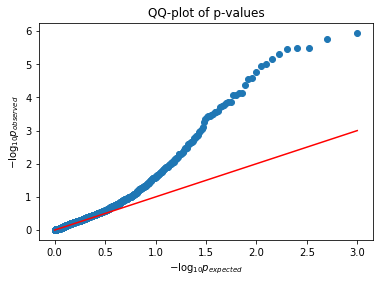

In [14]:
plt.scatter(x = sorted(-np.log10(np.arange(1,Ntests+1)/Ntests)), 
            y = sorted(-np.log10(res.pvalue)))

plt.plot(sorted(-np.log10(np.arange(1,Ntests+1)/Ntests)), 
         sorted(-np.log10(np.arange(1,Ntests+1)/Ntests)), 'r-')

plt.title('QQ-plot of p-values')
plt.xlabel(r'$-\log_{10}p_{expected}$')
plt.ylabel(r'$-\log_{10}p_{observed}$')
plt.show()

Is the number of FPs consistent with the false positive rate?

$$ FPR = \frac{FP}{FP+TN}$$

In [15]:
fpr = fp/(fp + sum(res.pvalue[TPtests:] >= 0.05))
print('FPR = %.3f' % fpr)

FPR = 0.053


##### Bonferroni correction
This is a more stringent correction that adjusts the significance cutoff $\alpha$ to account for the number of tests.
$$\alpha_{\text{Bonferroni}} = \frac{\alpha}{N}$$

In [16]:
alphaBonf = 0.05/Ntests
bonfSignificant = sum(res.pvalue < alphaBonf)
print('%d significant results after Bonferroni correction' % bonfSignificant)

bonfTP = sum(res.pvalue[:TPtests] < alphaBonf)
print('%d TPs after Bonferroni correction' % bonfTP)

bonfFP = sum(res.pvalue[TPtests:] < alphaBonf)
bonfFPR = bonfFP/(bonfFP + sum(res.pvalue[TPtests:] >= alphaBonf))
print('%d FPs after Bonferroni correction, FPR = %.3f' % (bonfFP, bonfFPR))

13 significant results after Bonferroni correction
13 TPs after Bonferroni correction
0 FPs after Bonferroni correction, FPR = 0.000


How did the number of true positives change after Bonferroni correction? How about the number of false positives?